In [11]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
from scipy.stats import iqr

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

annotation/ccf_2017


In [4]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [5]:
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

In [6]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [7]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [8]:
summary_structures = {}
for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
connectivity_data.summary_structures = summary_structures

connectivity_data.sum2_index_matrices = get_indices_2ormore(connectivity_data.summary_structures)

connectivity_data.get_cresum_combos()
connectivity_data.cresum2_index_matrices = get_indices_2ormore(connectivity_data.cresum_combos)
connectivity_data.cresum2_evalindices = get_eval_indices(connectivity_data.cresum2_index_matrices)


In [9]:
crelines = {}
for sid in major_structure_ids:
    crelines[sid] = connectivity_data.creline[sid]

In [16]:
norms = {}
iqs = {}
for m in range(12):
    sid = major_structure_ids[m]
    leaf_sid = np.asarray([ia_map[summary_structures[sid][i]] for i in range(len(summary_structures[sid]))])[connectivity_data.cresum2_evalindices[sid]]
    combo = pd.DataFrame(np.asarray([np.sum(connectivity_data.structure_datas[sid].reg_proj_injnorm, axis = 1)[connectivity_data.cresum2_evalindices[sid]], 
                 crelines[sid][connectivity_data.cresum2_evalindices[sid]],
                 leaf_sid]).transpose())
    combo.columns  = np.asarray(['Norm','Cre','Sum'])
    combo['Norm'] = pd.to_numeric(combo['Norm'])
    norms[sid] = combo.pivot_table(
            values='Norm', 
            index='Cre', 
            columns='Sum', 
            aggfunc=np.mean)
    iqs[sid] = combo.pivot_table(
            values='Norm', 
            index='Cre', 
            columns='Sum', 
            aggfunc=iqr)        

(0, 10)

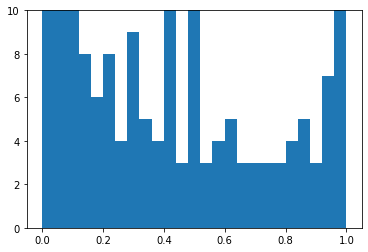

In [37]:
plt.hist(connectivity_data.structure_datas[sid].injections[0], bins = 25)
plt.ylim(0,10)

In [38]:
#plt.hist(connectivity_data.structure_datas[sid].injections)

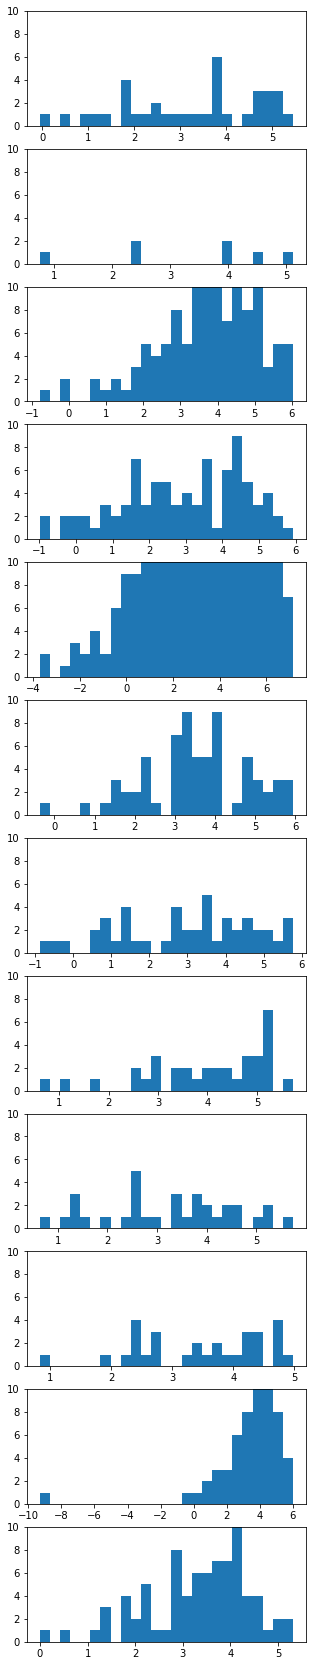

In [42]:
fig, axes = plt.subplots(12,1,figsize = (5,30))
for m in range(12):
    sid = major_structure_ids[m]
    axes[m].hist(np.log(connectivity_data.structure_datas[sid].reg_inj.sum(axis = 1)), bins=25)
    axes[m].set_ylim(0,10)

(0, 10)

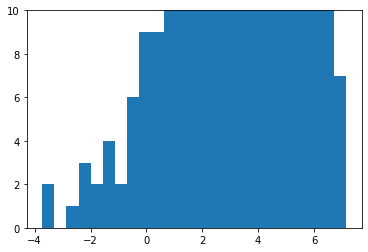

In [27]:
plt.hist(np.log(connectivity_data.structure_datas[315].reg_inj.sum(axis = 1)), bins=25)
plt.ylim(0,10)

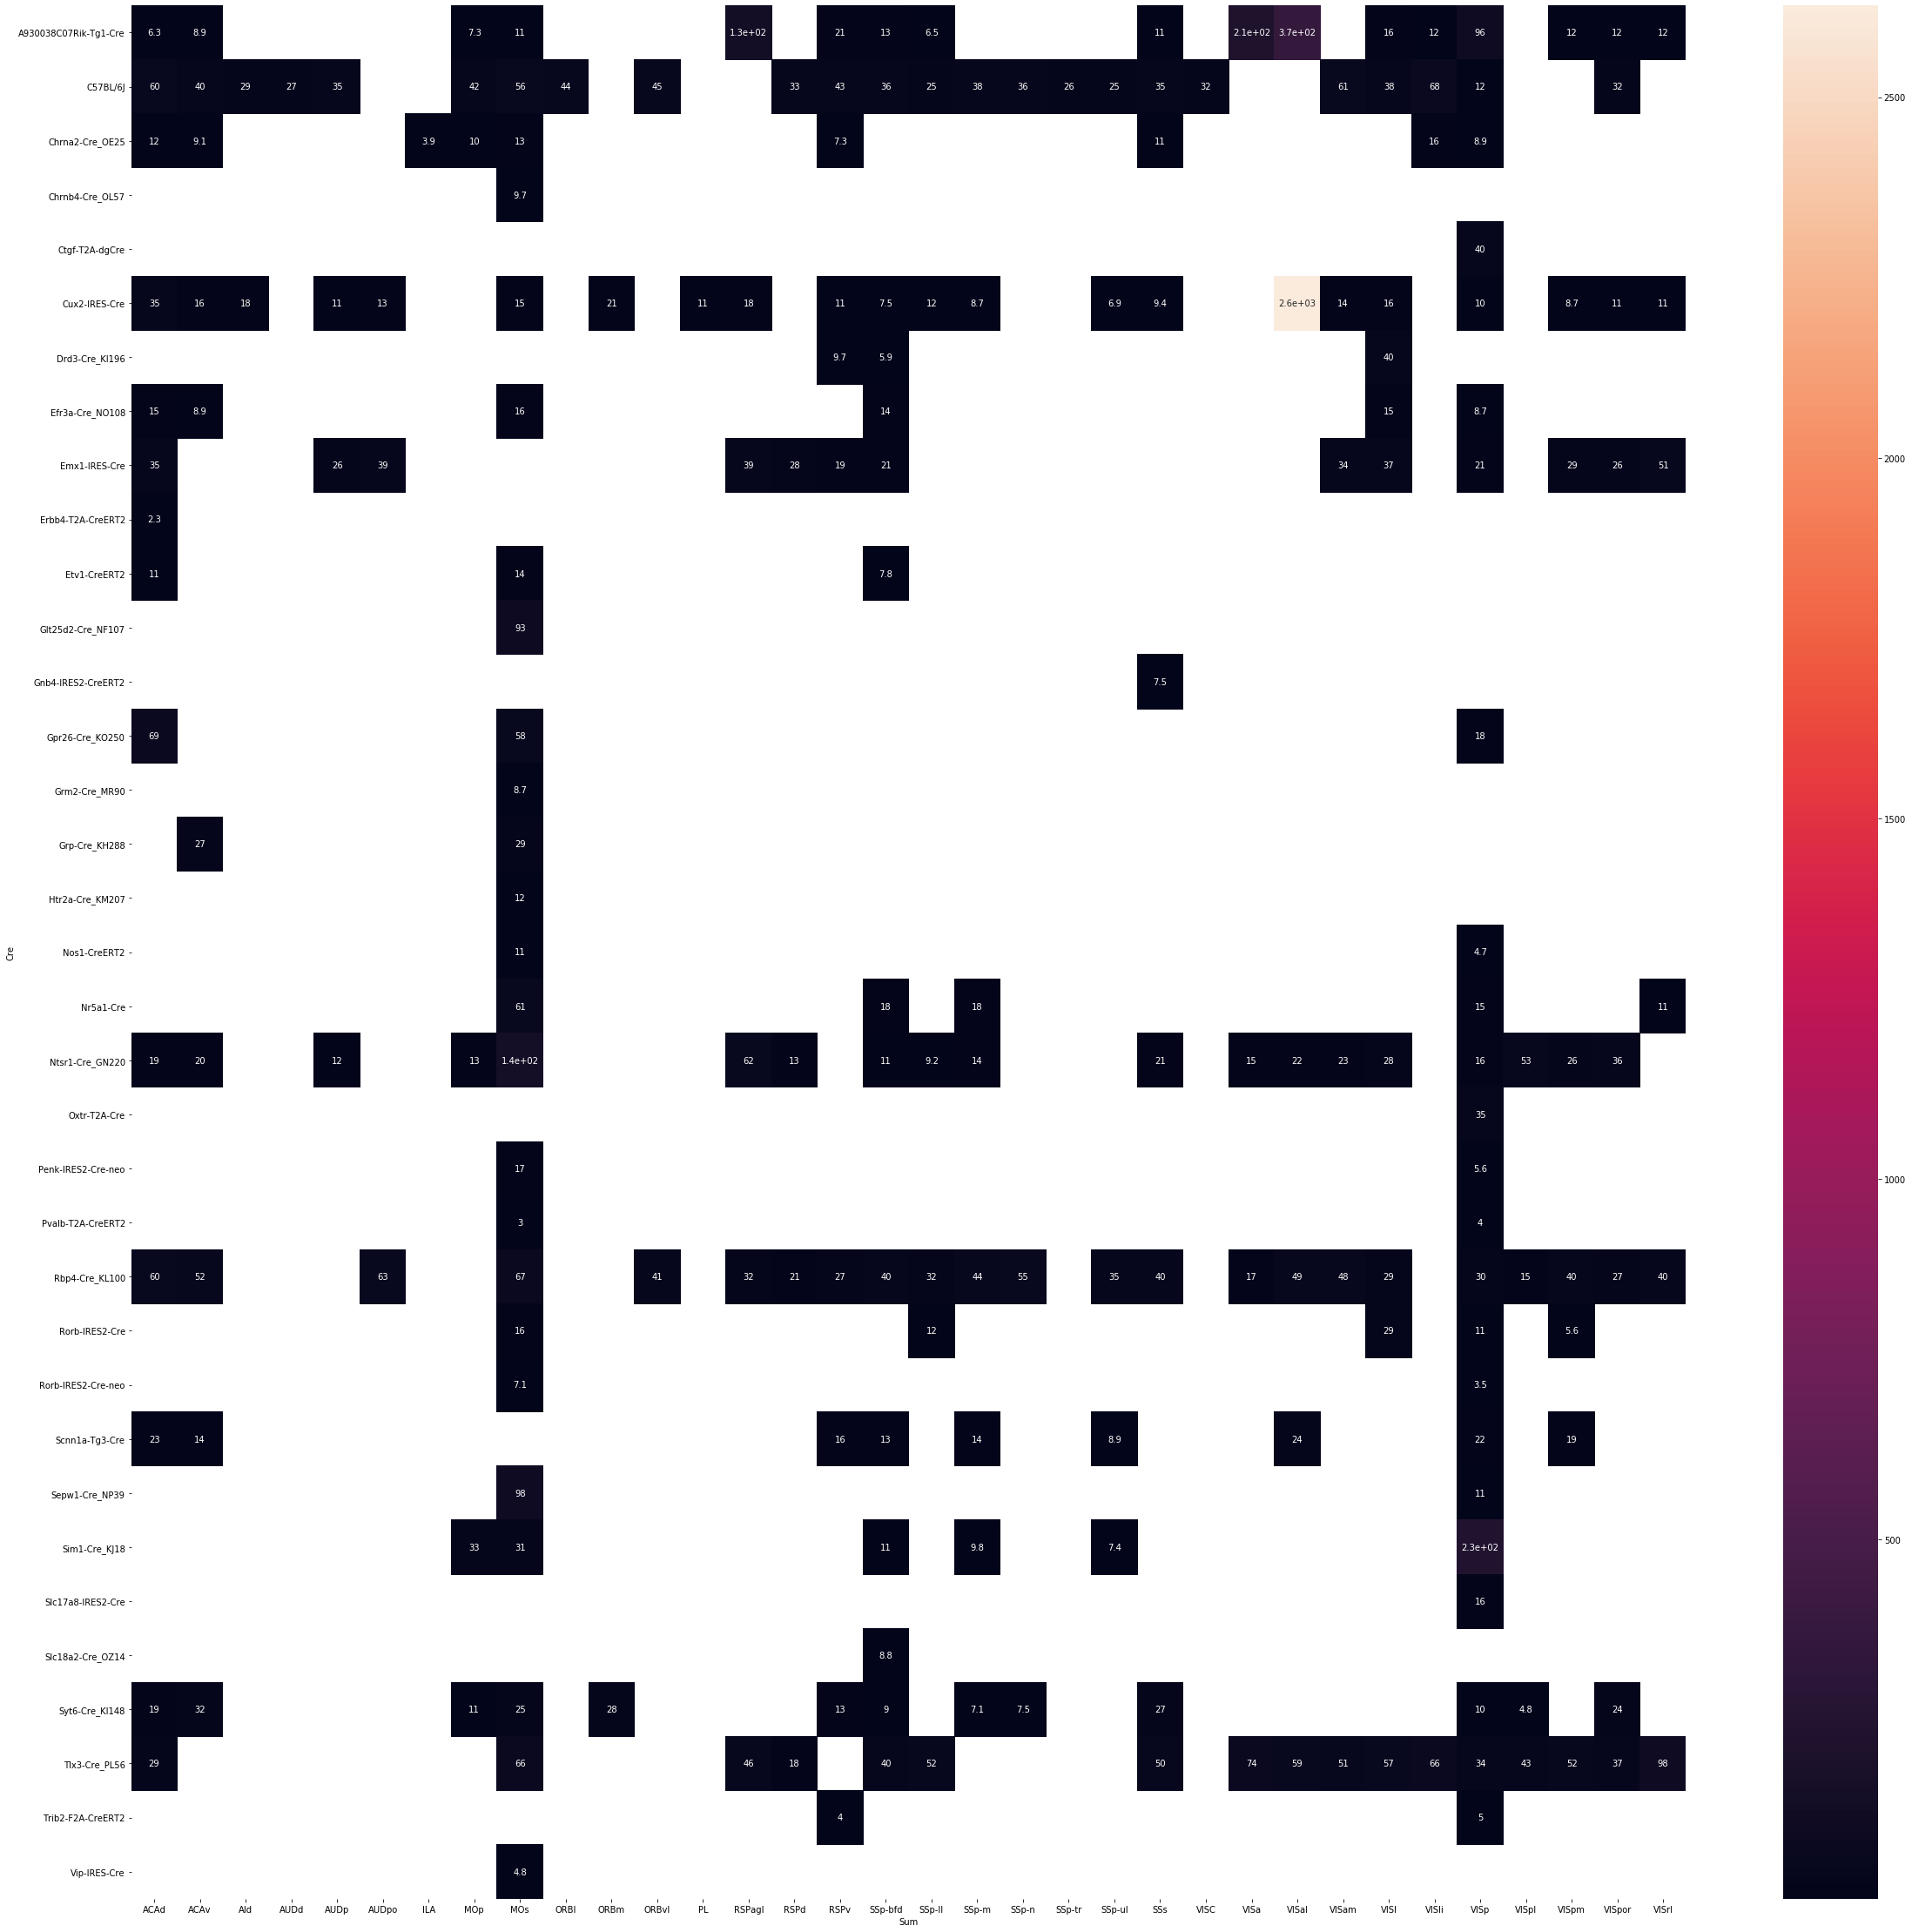

In [17]:
sid = 315
fig, ax = plt.subplots(1,1,figsize = (40,40))
sns.heatmap(norms[sid], annot = True, ax = ax)

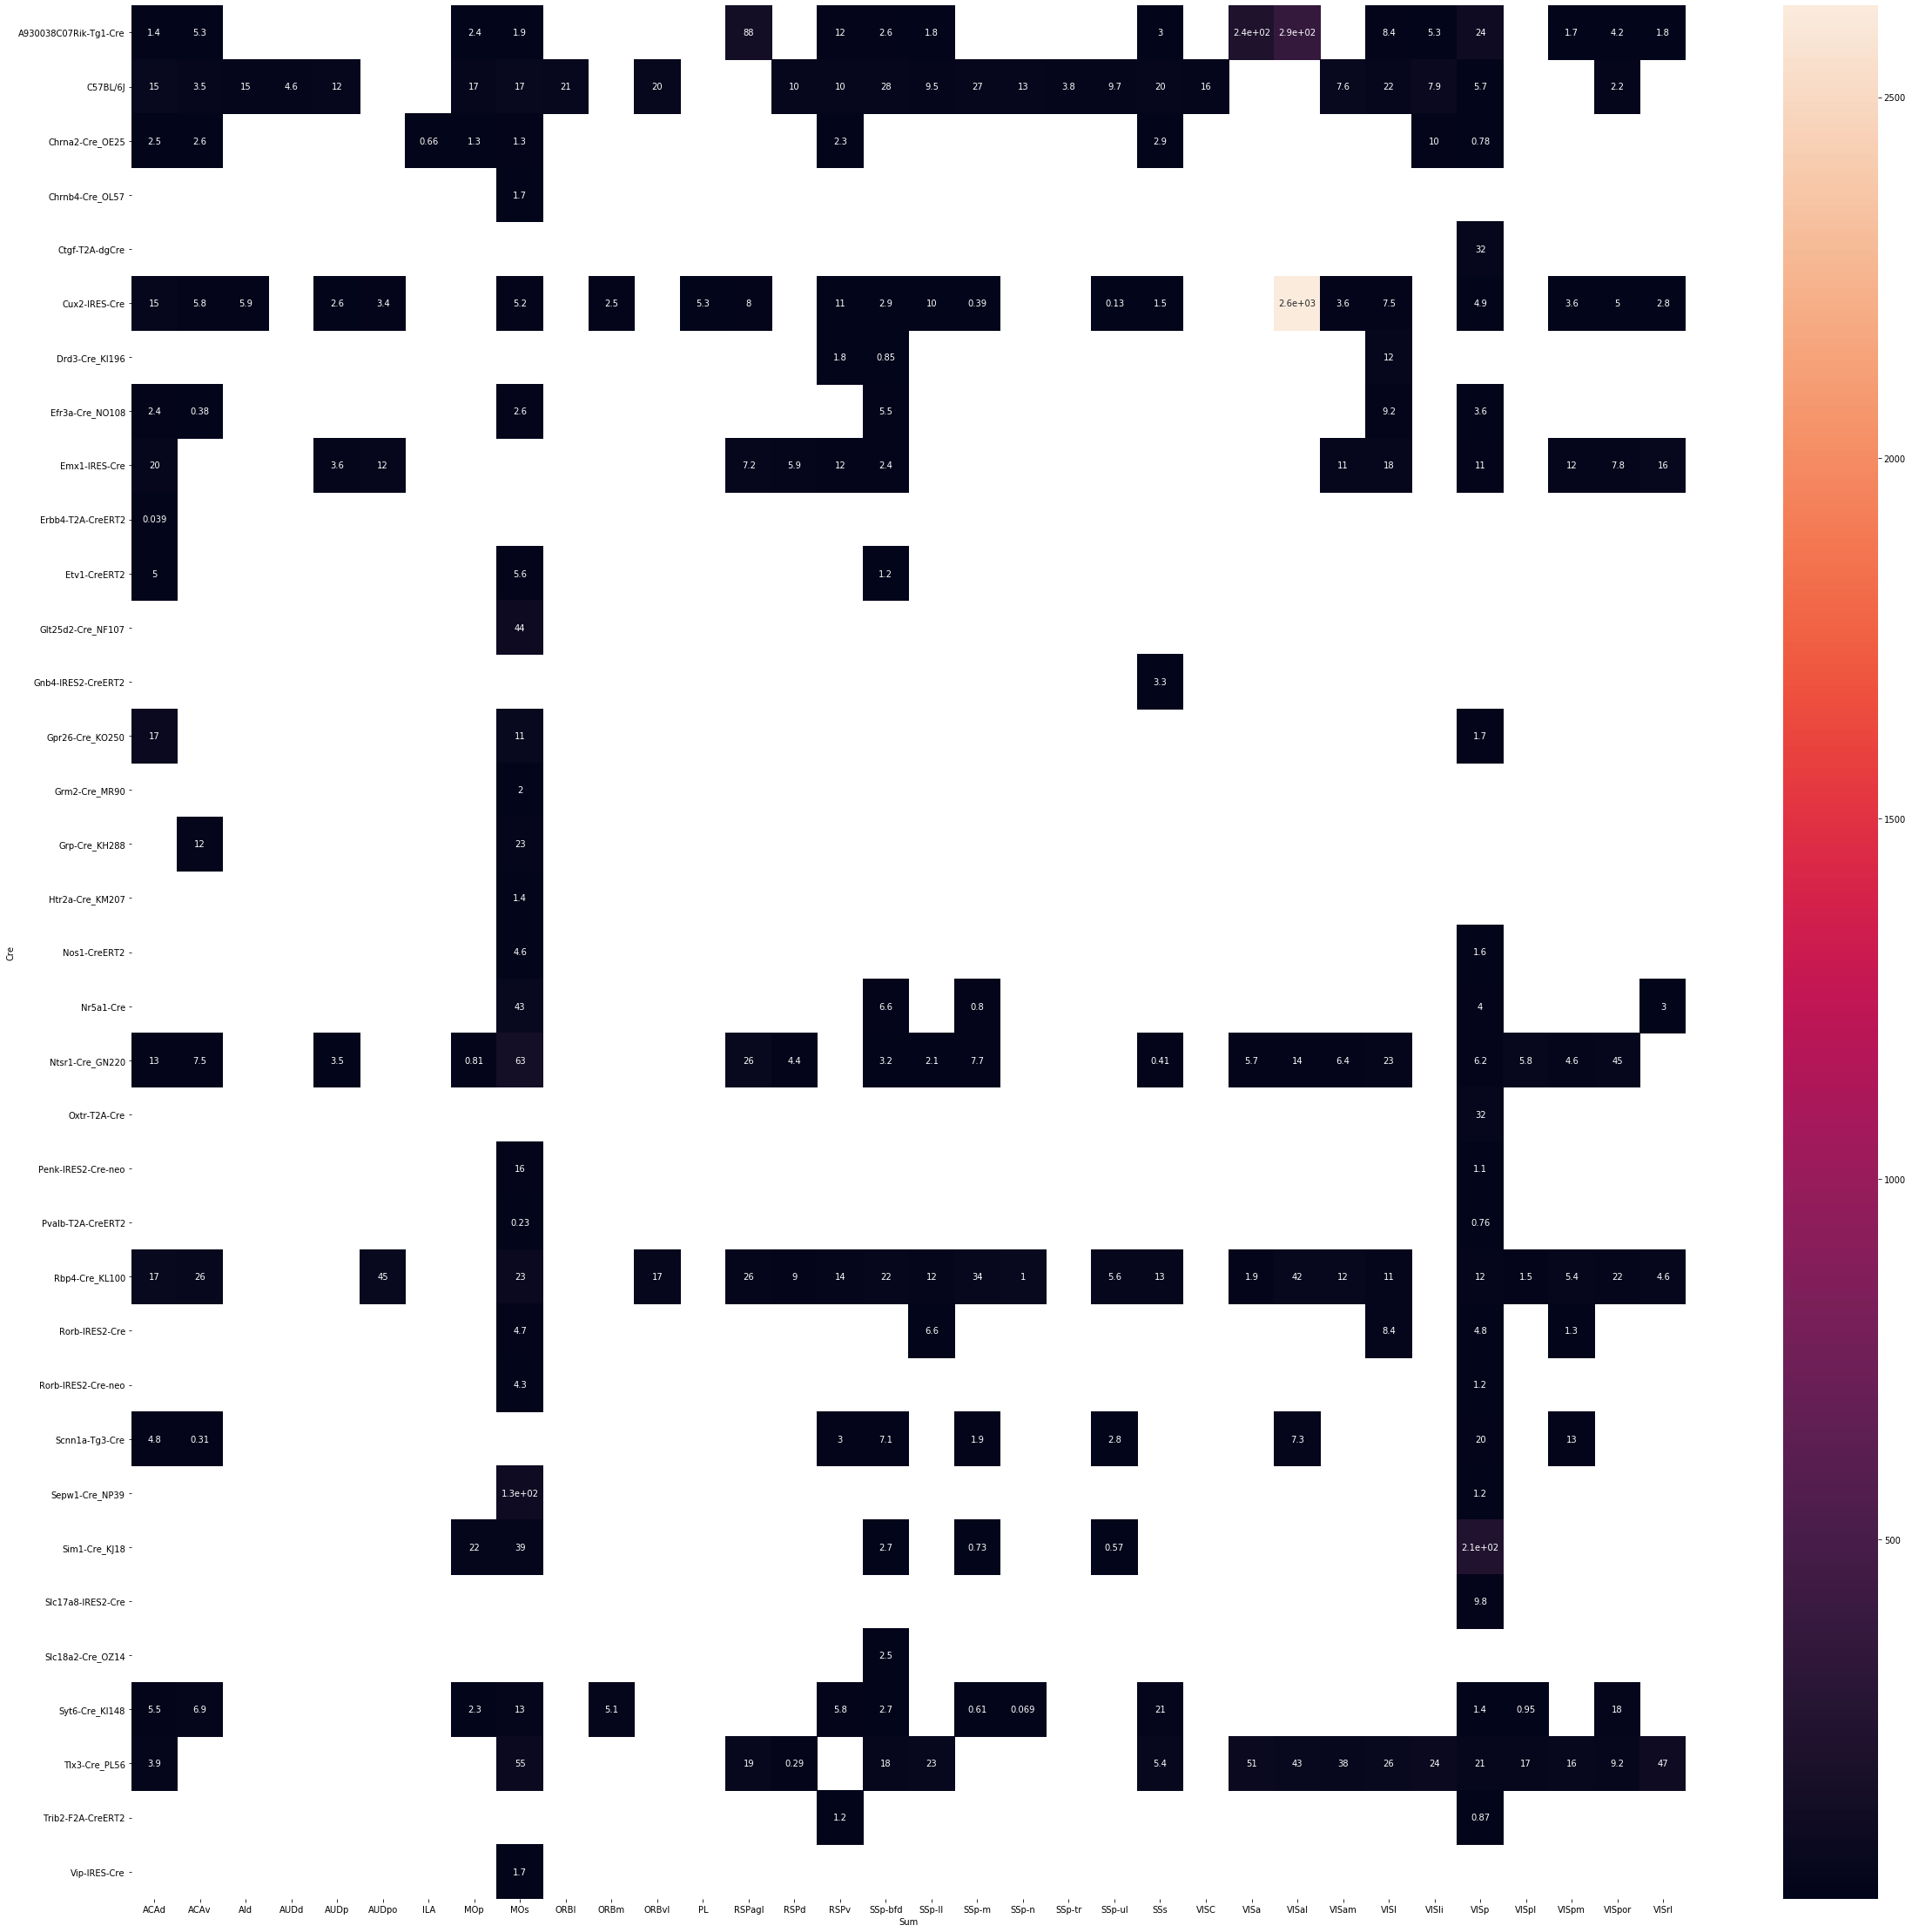

In [18]:
sid = 315
fig, ax = plt.subplots(1,1,figsize = (40,40))
sns.heatmap(norms[sid], annot = iqs[sid], ax = ax)

In [39]:
norms = {}
iqs = {}
for m in range(12):
    sid = major_structure_ids[m]
    leaf_sid = np.asarray([ia_map[summary_structures[sid][i]] for i in range(len(summary_structures[sid]))])[connectivity_data.cresum2_evalindices[sid]]
    combo = pd.DataFrame(np.asarray([np.sum(connectivity_data.structure_datas[sid].reg_proj, axis = 1)[connectivity_data.cresum2_evalindices[sid]], 
                 crelines[sid][connectivity_data.cresum2_evalindices[sid]],
                 leaf_sid]).transpose())
    combo.columns  = np.asarray(['Norm','Cre','Sum'])
    combo['Norm'] = pd.to_numeric(combo['Norm'])
    norms[sid] = combo.pivot_table(
            values='Norm', 
            index='Cre', 
            columns='Sum', 
            aggfunc=np.sum)
    iqs[sid] = combo.pivot_table(
            values='Norm', 
            index='Cre', 
            columns='Sum', 
            aggfunc=iqr)

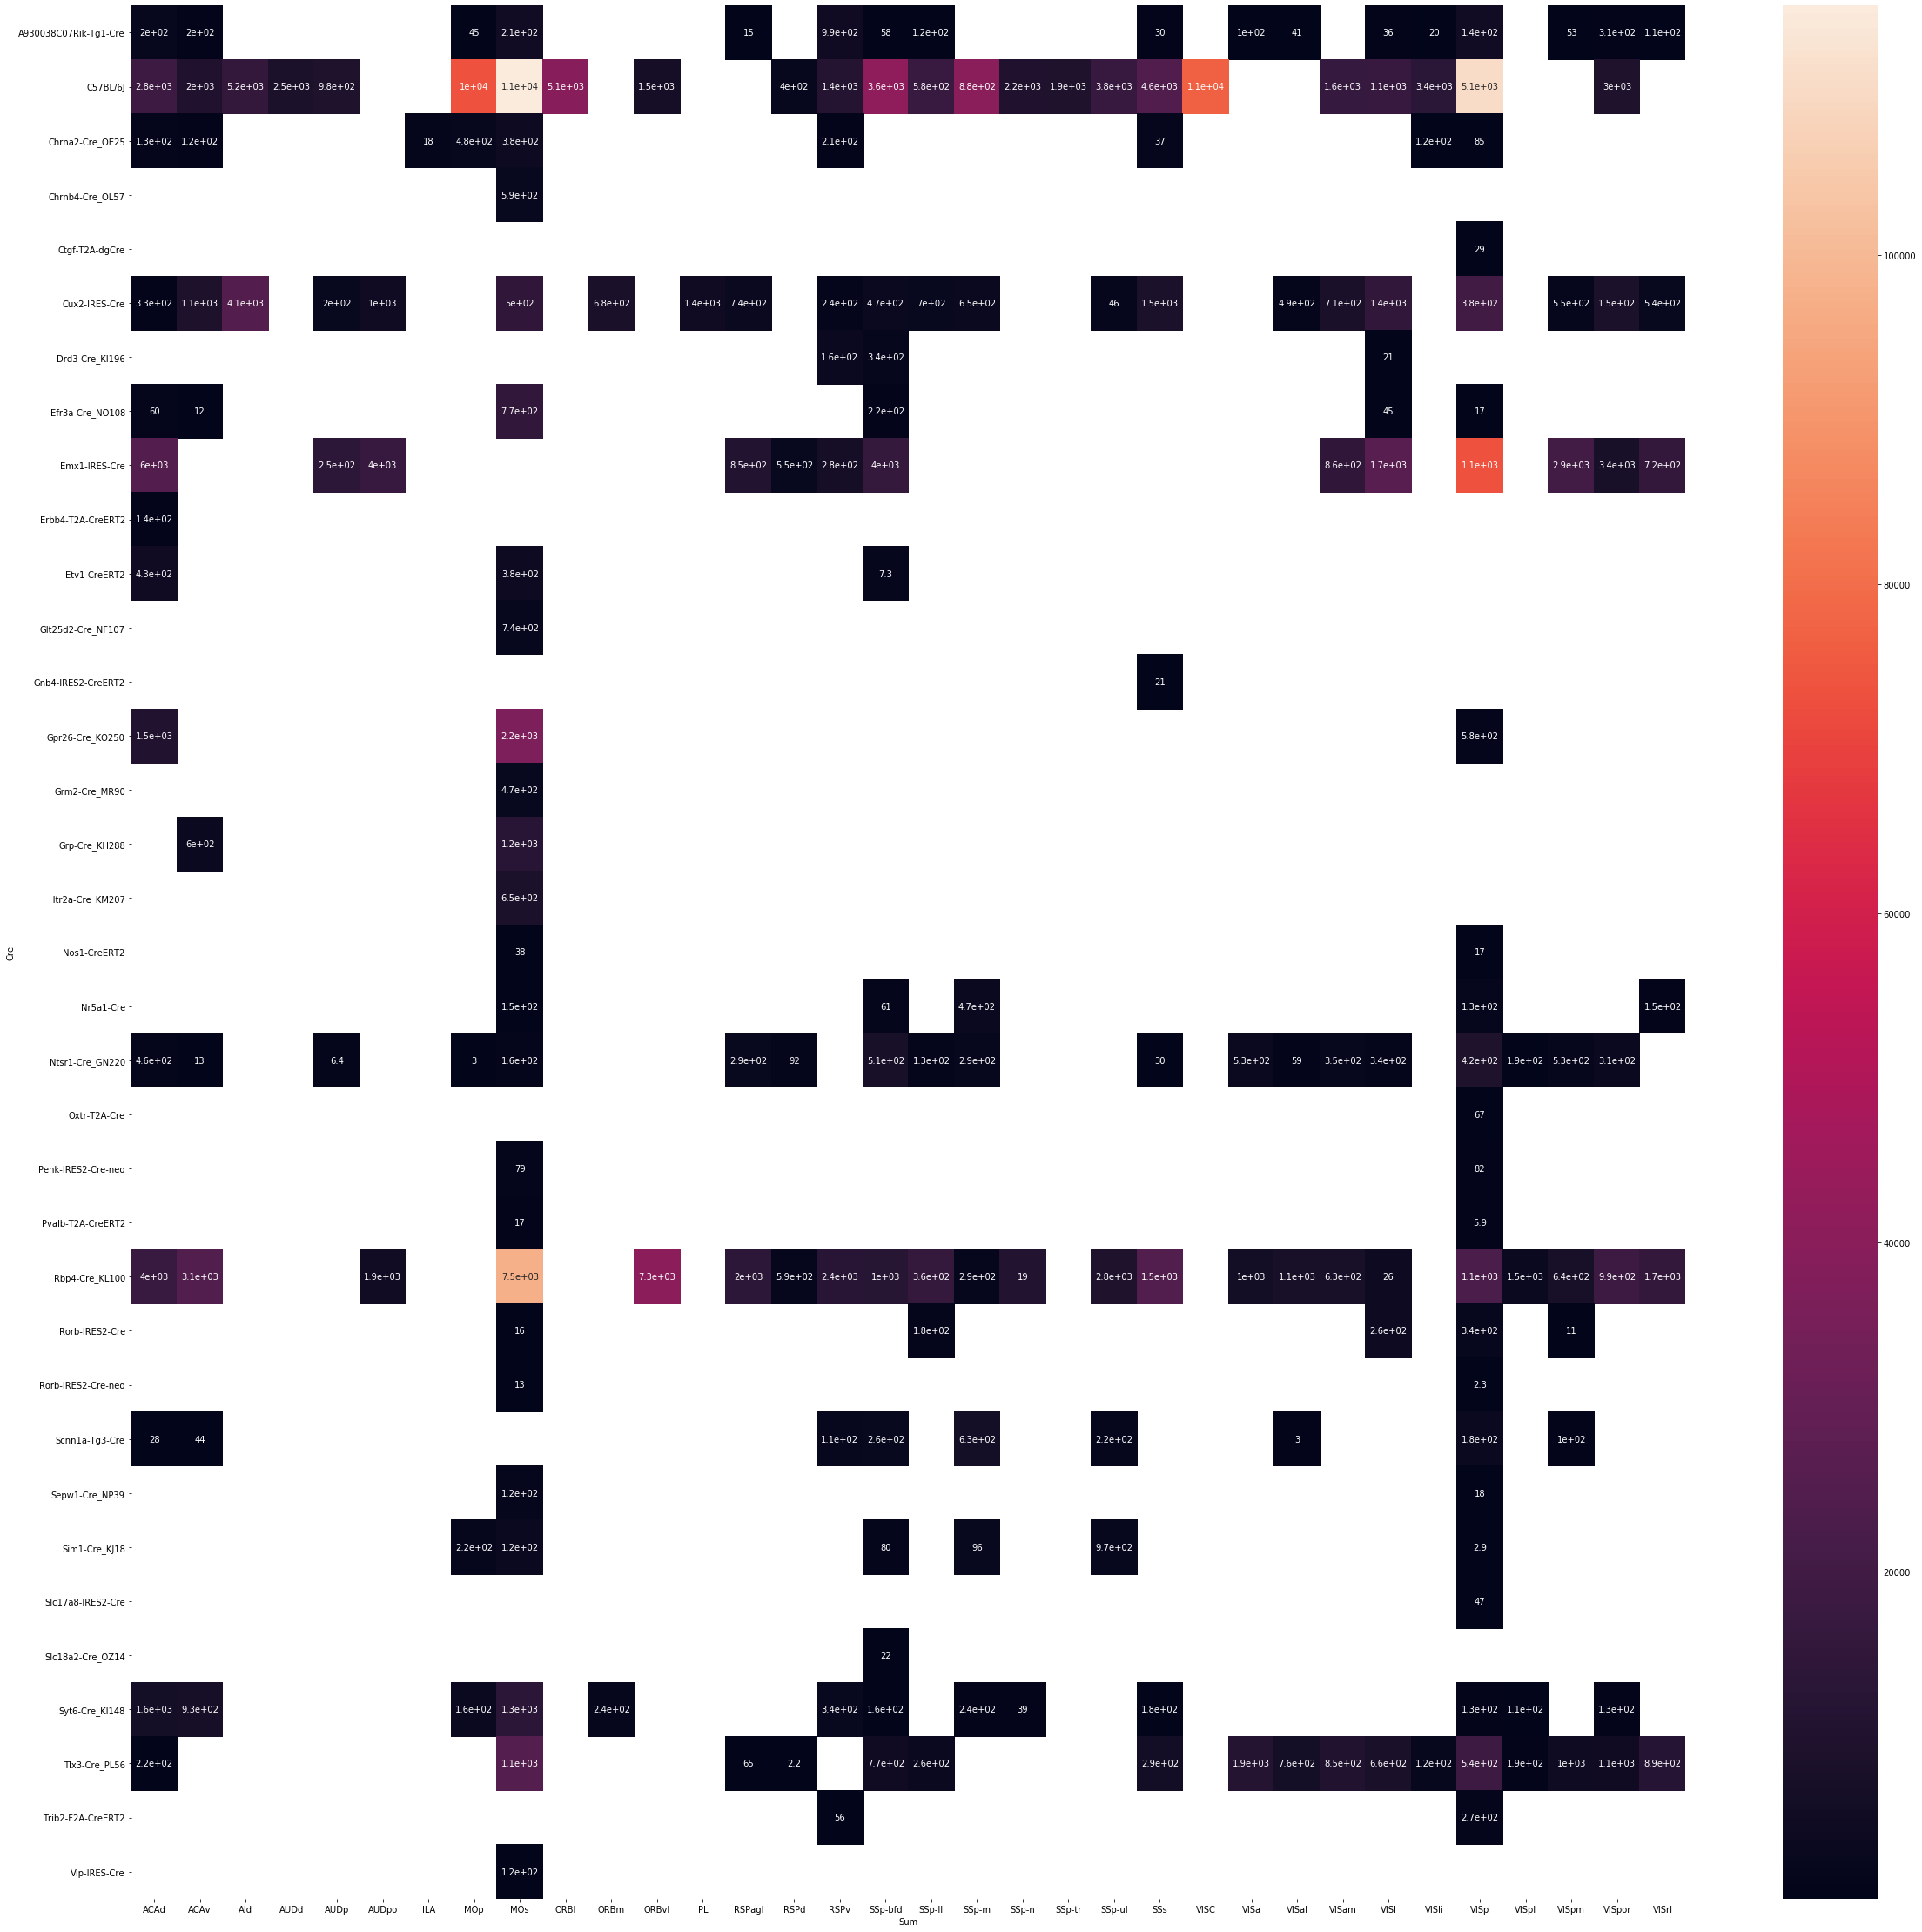

In [44]:
sid = 315
fig, ax = plt.subplots(1,1,figsize = (40,40))
sns.heatmap(norms[sid], annot = iqs[sid], ax = ax)

In [36]:
scipy.stats.iqr

313

0
1
2
3
4
5
6
7
8
9
10
11


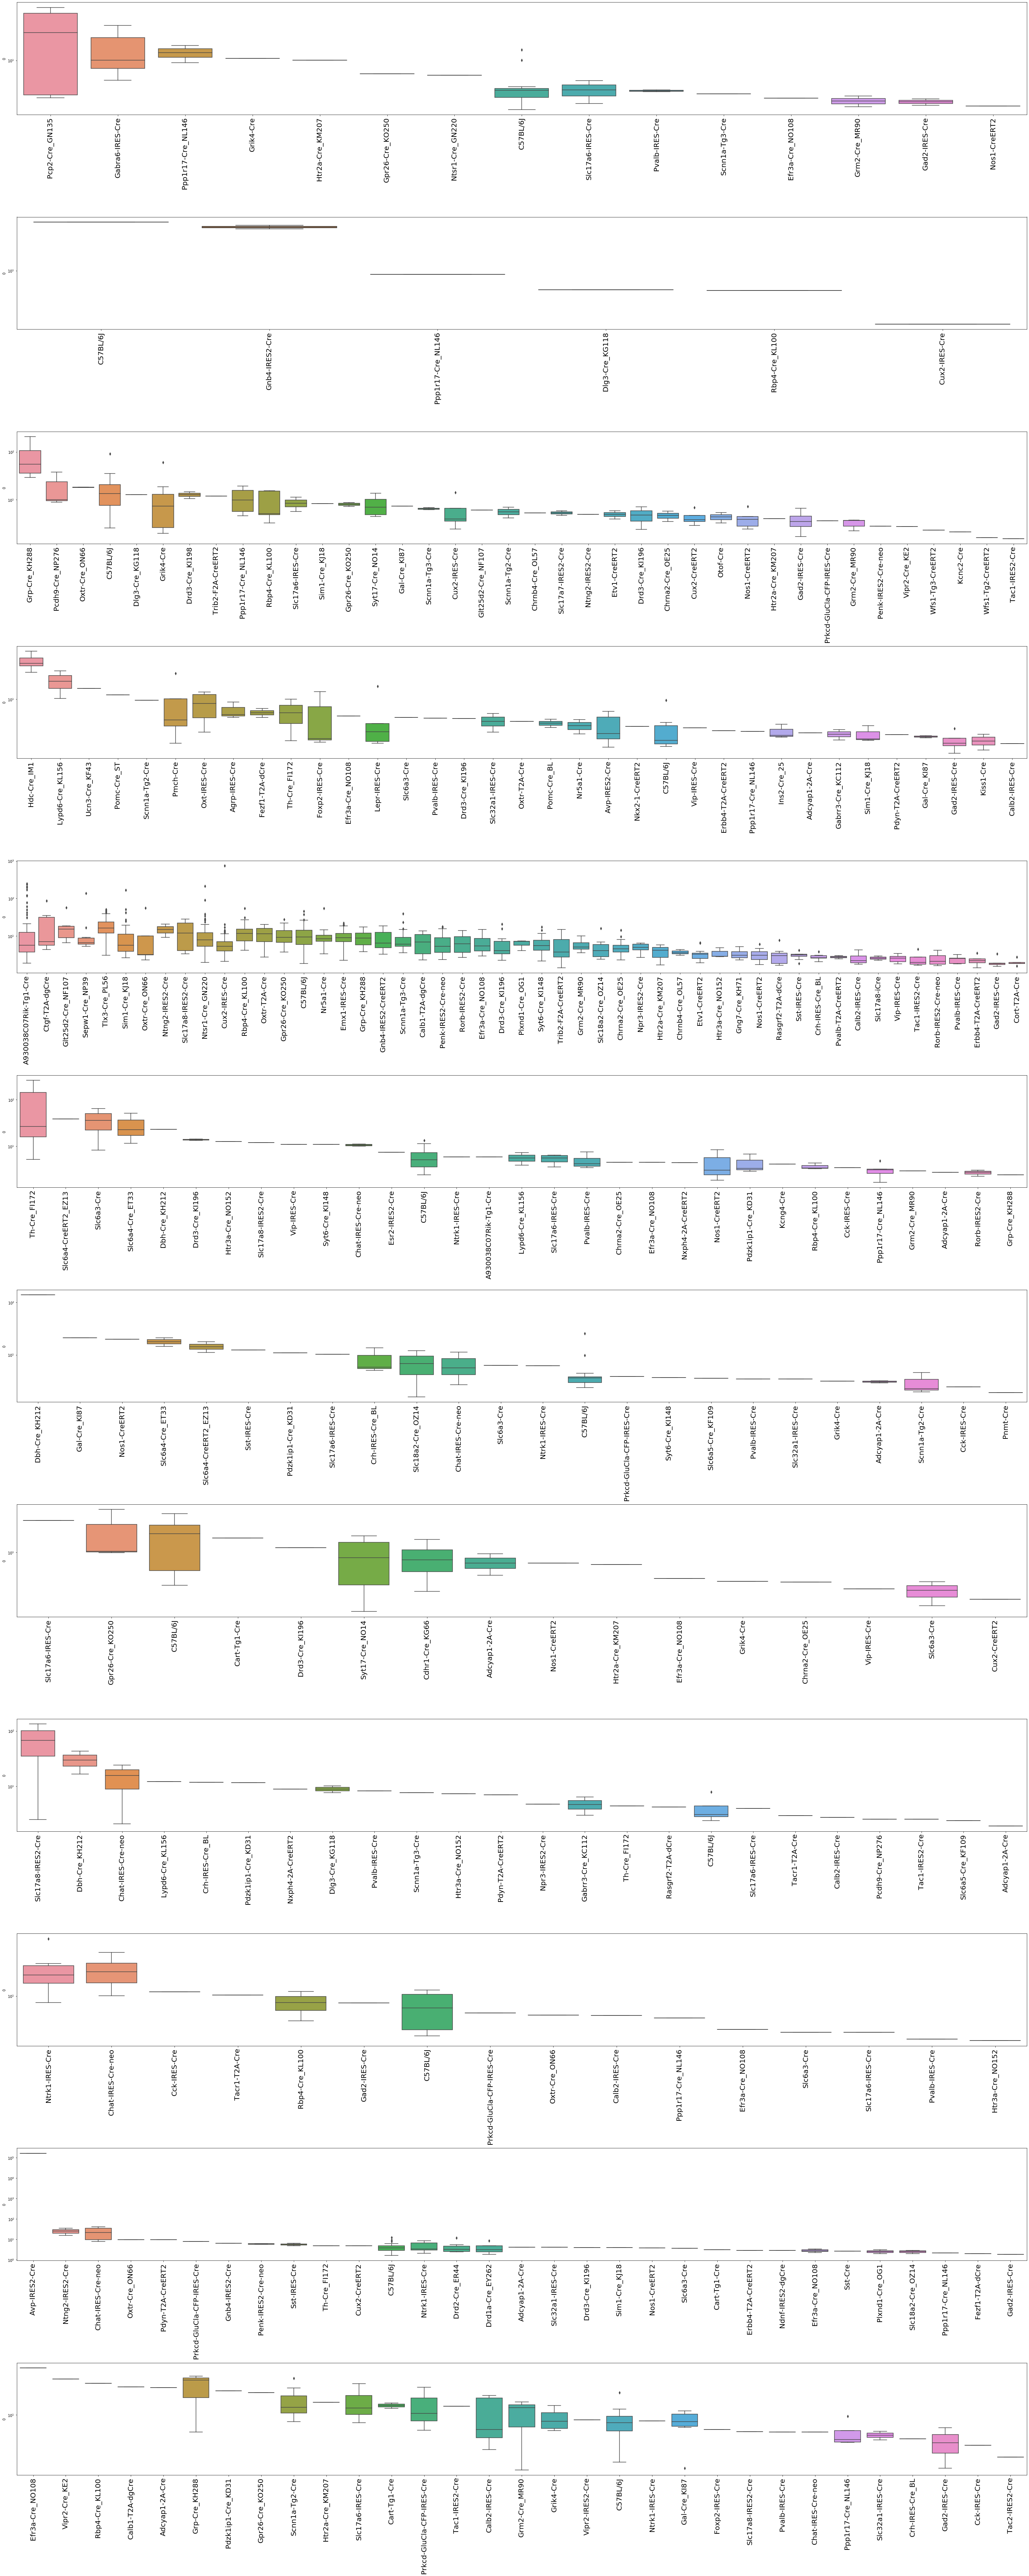

In [7]:
%matplotlib inline
nms = len(major_structure_ids)
fig, axes = plt.subplots(nms,1, figsize = (40,100))
#for m in range(1):
for m in range(12):
    print(m)
    sid = major_structure_ids[m]
    
    proj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj, axis = 1)
    inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
    proj_injnorm_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj_injnorm, axis = 1)
    #inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
        
    #    projnorm_bycre = pd.DataFrame([proj_norm, connectivity_data.creline[sid]]).transpose()
    #projnorm_byleaf = pd.DataFrame(np.asarray([proj_norm, leafs[sid]]).transpose())
    #     injnorm_bycre = pd.DataFrame(np.asarray([inj_norm, connectivity_data.creline[sid]]).transpose())
#     injnorm_byleaf = pd.DataFrame(np.asarray([inj_norm, leafs[sid]]).transpose())
    proj_injnorm_bycre = pd.DataFrame(np.asarray([proj_injnorm_norm, connectivity_data.creline[sid]]).transpose())
#     proj_injnorm_byleaf = pd.DataFrame(np.asarray([proj_injnorm_norm, leafs[sid]]).transpose())    
        
#     losses_bycre = projnorm_bycre.astype({0: np.float64})
    proj_injnorm_bycre = proj_injnorm_bycre.astype({0: np.float64})
    order = np.unique(proj_injnorm_bycre[1])[(-proj_injnorm_bycre.groupby(by=[1])[0].mean()).argsort()]
    sns.boxplot(x =  connectivity_data.creline[sid], y = proj_injnorm_bycre.loc[:,0], ax=axes[m], order = order)
    axes[m].set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 20)

    axes[m].set_yscale('symlog', linthreshy=1e0)

plt.tight_layout() 


In [8]:
m = 4
fig, axes = plt.subplots(figsize = (10,20))
sid = major_structure_ids[m]

proj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj, axis = 1)
inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
proj_injnorm_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj_injnorm, axis = 1)
#inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)

#    projnorm_bycre = pd.DataFrame([proj_norm, connectivity_data.creline[sid]]).transpose()
#projnorm_byleaf = pd.DataFrame(np.asarray([proj_norm, leafs[sid]]).transpose())
#     injnorm_bycre = pd.DataFrame(np.asarray([inj_norm, connectivity_data.creline[sid]]).transpose())
#     injnorm_byleaf = pd.DataFrame(np.asarray([inj_norm, leafs[sid]]).transpose())
proj_injnorm_bycre = pd.DataFrame(np.asarray([proj_injnorm_norm, connectivity_data.creline[sid]]).transpose())
#     proj_injnorm_byleaf = pd.DataFrame(np.asarray([proj_injnorm_norm, leafs[sid]]).transpose())    

#     losses_bycre = projnorm_bycre.astype({0: np.float64})
proj_injnorm_bycre = proj_injnorm_bycre.astype({0: np.float64})
order = np.unique(proj_injnorm_bycre[1])[(-proj_injnorm_bycre.groupby(by=[1])[0].mean()).argsort()]
sns.boxplot(x =  connectivity_data.creline[sid], y = proj_injnorm_bycre.loc[:,0], ax=axes, order = order)
axes.set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 20)

axes.set_yscale('symlog', linthreshy=1e0)


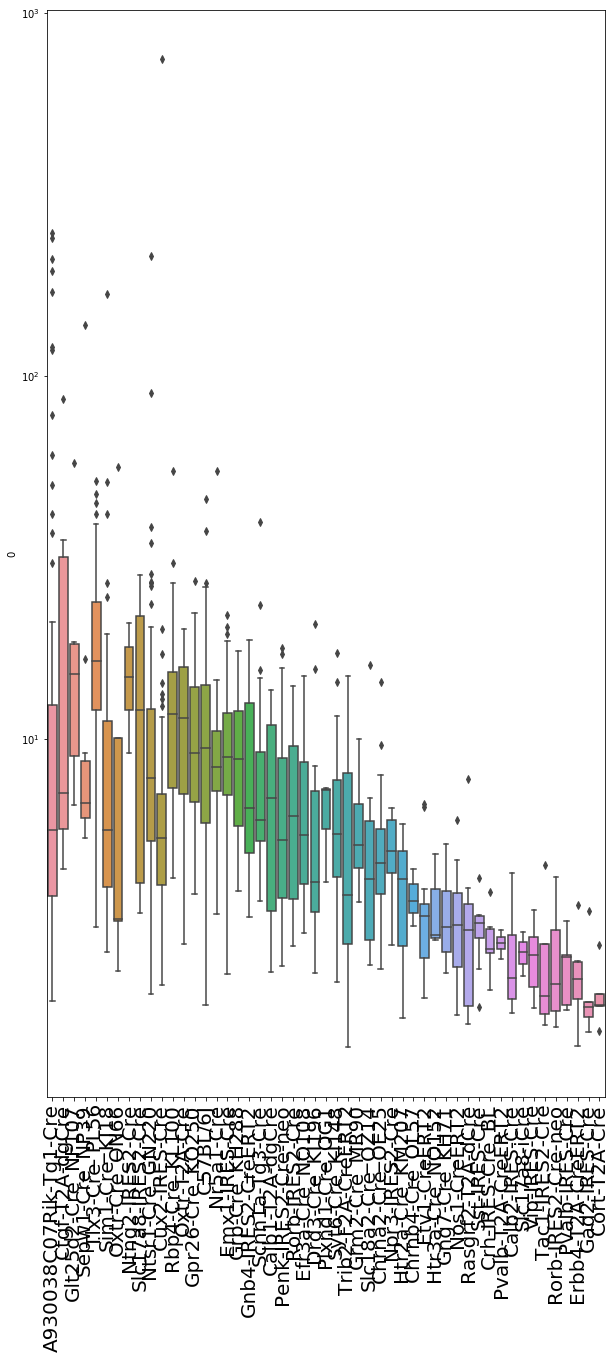

In [10]:
m = 4
fig, axes = plt.subplots(figsize = (10,20))
sid = major_structure_ids[m]

proj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj, axis = 1)
inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
proj_injnorm_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj_injnorm, axis = 1)
proj_injnorm_bycre = pd.DataFrame(np.asarray([proj_injnorm_norm, connectivity_data.creline[sid]]).transpose())
proj_injnorm_bycre = proj_injnorm_bycre.astype({0: np.float64})
order = np.unique(proj_injnorm_bycre[1])[(-proj_injnorm_bycre.groupby(by=[1])[0].mean()).argsort()]
sns.boxplot(x =  connectivity_data.creline[sid], y = proj_injnorm_bycre.loc[:,0], ax=axes, order = order)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90, fontsize = 20)

axes.set_yscale('symlog', linthreshy=1e0)


In [ ]:
sid = 315
ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
crs = connectivity_data.creline[sid]
df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
df.columns = np.asarray(['Leaf', 'Creline','present'])
a = df.pivot_table(values='present',index='Leaf',columns='Creline',aggfunc=np.sum)
a = a.fillna(0)
revels = a
ticks=np.arange(revels.values.min(),revels.values.max()+1 )
boundaries = np.arange(revels.values.min()-.5,revels.values.max()+1.5 )
cmap = plt.get_cmap("YlOrRd", revels.values.max()-revels.values.min()+1)
fig, ax = plt.subplots(figsize = (15,15))
tops = np.argsort(-np.sum(revels.loc[np.asarray(['VISp2/3','VISp4' ,'VISp5' ,'VISp6a'  ])], axis = 0))[:10]
rts = revels.loc[np.asarray(['VISp2/3','VISp4' ,'VISp5' ,'VISp6a'  ])].iloc[:,tops]
sns.heatmap(rts, annot=True, linewidths=0.4, cmap=cmap,
        cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)
ax.set_xlabel('Cre' , fontsize = 30)
ax.set_ylabel('Leaf' , fontsize = 30)
ax.set_title('Centroid counts in VISp', fontsize = 40)
#plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/figures/visp_counts')